## 🐈 Building the model

In the journey of building a machine learning model, one of the first decisions is choosing the right type of model—predictive or generative. Predictive models focus on forecasting outcomes based on input data, while generative models aim to learn the underlying distribution of data to generate new samples.

Our usecase is categorized under predictive machine learning. There are many different ways to build a predictive model. For our use case, we chose neural networks. It has the ability to generalize better, handle complex patterns, and more expressive.

## 🐠 Install & Import packages

Again, we will need to install and import packages as we develop our notebook.

This will take a couple of minutes, and if `pip` gives an Error, don't worry about it. Things will just run fine regardless.

In [1]:
!pip -q install keras "tensorflow==2.15.1" "tf2onnx" "onnx" "seaborn" "onnxruntime"


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from pathlib import Path
import pickle
import os
import logging, warnings
import random

# Suppress warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
# from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Input, Concatenate
from tensorflow.keras.models import Model
import tf2onnx
import onnx
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
import onnxruntime as rt

#Set some seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# 📦 Load Data

We again load our two datasets, merge them, drop the NA columns just like before and select the input and output data.

Input data (X) is the feature matrix that contains the characteristics of each song.

Output data (y)is the target variable the model is trying to predict. In this case, y is the 'country' column which represents the country where the song is popular. The model will learn to predict the country based on the song features in X.

In [3]:
song_properties = pd.read_parquet('https://github.com/rhoai-mlops/jukebox/raw/refs/heads/main/99-data_prep/song_properties.parquet')
song_rankings = pd.read_parquet('https://github.com/rhoai-mlops/jukebox/raw/refs/heads/main/99-data_prep/song_rankings.parquet')
song_properties.keys()

Index(['spotify_id', 'name', 'artists', 'snapshot_date', 'is_explicit',
       'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

In [4]:
# Remove missing values (NaNs) from the dataset
song_rankings = song_rankings.dropna()

Before training the model, we need to prepare the data properly:  

1. Encoding the Target Variable (`y`):  Our target variable (`y`) is the **country** where a song is popular. However, machine learning models work with numbers, not text labels. We use a Label Encoder to convert country names into numerical values.  

2. Splitting the Data: We split the dataset into training, validation, and test sets to ensure the model generalizes well.  
   - Training set (`X_train, y_train`): Used to train the model.  
   - Validation set (`X_val, y_val`): Helps fine-tune the model and avoid overfitting.  
   - Test set (`X_test, y_test`): Used at the very end to evaluate how well the model performs on unseen data.  

1. Feature Scaling: Since our input features (e.g., `duration_ms`, `danceability`, `loudness`) have different ranges, we scale them between 0 and 1 using `MinMaxScaler`. This prevents large-valued features from dominating smaller ones and helps the model learn efficiently. 

In [5]:
# X is the input fetures we want to train the model on while y is the output feature we want the model to predict.
X = song_rankings.merge(song_properties, on='spotify_id', how='left')
X = X[['is_explicit', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
y = song_rankings['country']

# We use a label encoder to get numbers instead of country codes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = tf.keras.utils.to_categorical(y_encoded)

# Split the data into training and testing sets so you have something to test the trained model with.
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size = 0.2, shuffle = False, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, stratify = y_train, random_state=SEED)

# Scale the data to remove mean and have unit variance. The data will be between -1 and 1, which makes it a lot easier 
# for the model to learn than random (and potentially large) values.
# It is important to only fit the scaler to the training data, otherwise you are leaking information about the global 
# distribution of variables (which is influenced by the test set) into the training set.
scaler = MinMaxScaler()
scaled_x_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
scaled_x_val = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
scaled_x_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns).astype(np.float32)

# 🛟 Prepare to save the model

Before we start building neural network and training the model, let's prepare the environment to store the resulting artifacts. 

We need to store our model artifacts in an S3 buckets with folder called models/model-name/version/ for versioning reasons.

In [6]:
# create local directories to save the model artifacts before starting building neural network and training the model
Path("models/jukebox/1/artifacts").mkdir(parents=True, exist_ok=True)

with open("models/jukebox/1/artifacts/scaler.pkl", "wb") as handle:
    pickle.dump(scaler, handle)

with open("models/jukebox/1/artifacts/label_encoder.pkl", "wb") as handle:
    pickle.dump(label_encoder, handle)

with open("models/jukebox/1/artifacts/y_test.pkl", "wb") as handle:
    pickle.dump(y_test, handle)

X_train.to_parquet("models/jukebox/1/artifacts/X_train.parquet")
X_test.to_parquet("models/jukebox/1/artifacts/X_test.parquet")

# 🚀 Build the model

The below piece of code is like creating a smart helper, aka Model, that learns to guess which countries might like a song based on its characteristics (its features). To process these features, our model will pass them through multiple layers of "neurons". These work much like in our brain and the more layers and neurons it has, the more capacity it has for learning.

At the end, our model uses what it learned to predict the countries that would enjoy the song the most. 

Finally, we check how well our model is doing at making these guesses!

In [7]:
# Have a dense layer for each individual input?
inputs = [Input(shape=(1,), name=name) for name in X.columns]
concatenated_inputs = Concatenate(name="input")(inputs)
x = Dense(32, activation='relu', name="dense_0")(concatenated_inputs)
x = Dense(64, name="dense_1")(x)
x = Activation('relu')(x)
x = Dense(128, name="dense_2")(x)
x = Activation('relu')(x)
x = Dense(256, name="dense_3")(x)
x = Activation('relu')(x)
output = Dense(y_one_hot.shape[1], activation='softmax', name="dense_4")(x)
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# 🪿 Model Summary
Now let's run `model.summary()` which prints out the blueprint of your music recommendation helper. 

When you run it, you'll see a long table that shows all the different processing stages your song features go through before turning into country predictions (please don't be scared of the output lenght!).

The table shows each layer of your music brain 🧠, starting with how it receives the song characteristics, then how it processes them through various "thinking layers" (those `Dense` and `Activation` parts), and finally how it produces its country predictions.

For each layer, you'll see its name, the shape of information flowing through it (like how many numbers are being processed), and how many "learning knobs" (`parameters`) that layer has to adjust as it gets better at predictions 🤓

At the bottom, you'll see the total number of these learning knobs which tells you how complex your recommendation system is. A higher number means your system can potentially learn more complex patterns in music preferences across different countries. (that's why you keep hearing number of parameters a lot in LLM conversations as well)

This summary can help you understand the complexity of your music recommendation system without needing to understand all the math happening behind the scenes.

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 is_explicit (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 duration_ms (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 danceability (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 energy (InputLayer)         [(None, 1)]                  0         []                            
                                                                                              

# 🏃 Train the Model

Now we train our smart helper to predict which country might like a song based on its features. We set it to learn from the training data for 2 epochs, which means that it sees the full dataset two times. During each round, it looks at the song characteristics (scaled_x_train) and the country labels (y_train). It also predicts on a separate dataset called the validation dataset (X_val and y_val) after each epoch. This is to see how well it does on data it hasn't trained on yet.
Remember we split the data into three in an above cell. That was the reason :)

Once the training is finished, we print a message to let us know that our model is ready to make predictions!

In [10]:
feature_names = list(X_train.columns)

train_features = [scaled_x_train[[name]].to_numpy() for name in feature_names]
val_features = [scaled_x_val[[name]].to_numpy() for name in feature_names]

train_feature_dataset = tf.data.Dataset.zip(tuple(
    tf.data.Dataset.from_tensor_slices(f) for f in train_features
))
val_feature_dataset = tf.data.Dataset.zip(tuple(
    tf.data.Dataset.from_tensor_slices(f) for f in val_features
))

train_dataset = tf.data.Dataset.zip((train_feature_dataset, tf.data.Dataset.from_tensor_slices(y_train)))
val_dataset = tf.data.Dataset.zip((val_feature_dataset, tf.data.Dataset.from_tensor_slices(y_val)))

train_dataset = train_dataset.shuffle(buffer_size=len(y_train), seed=42, reshuffle_each_iteration=False)
train_dataset = train_dataset.batch(32)
val_dataset = val_dataset.batch(32)

In [11]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset, 
    epochs=1, 
    verbose=True
)

22322/22322 [==============================] - 43s 2ms/step - loss: 3.0426 - accuracy: 0.2222 - precision: 0.8101 - recall: 0.0710 - val_loss: 2.4640 - val_accuracy: 0.3384 - val_precision: 0.8236 - val_recall: 0.1732


# 🫡 Save the Model

Here we convert our trained song prediction model into a popular format called ONNX.  
We also save the original Keras model for use later on so we easier can scan it.

In [12]:
input_signature = [tf.TensorSpec(i.shape, i.dtype, i.name) for i in model.inputs]
model.output_names = ['output']
onnx_model_proto, _ = tf2onnx.convert.from_keras(model, input_signature)
onnx.save(onnx_model_proto, "models/jukebox/1/model.onnx")

model.save('models/jukebox/1/model.keras')

### Quiz Time 🤓

In [13]:
import sys
import os
sys.path.append(os.path.abspath('../.dontlookhere/'))
try: from quiz2 import *
except: pass

In [14]:
try: quiz_model() 
except: pass

Which type of machine learning model did K.R.A.P. Records choose for Jukebox AI project?


Dropdown(description='Choose:', options=('Generative model', 'Predictive model', 'Descriptive model'), value=N…

Output()

In [15]:
try: quiz_nn()
except: pass

Why did K.R.A.P. Records decide to use neural networks for their predictive model?


Dropdown(description='Choose:', options=('Because they can generalize better and handle complex patterns', 'Be…

Output()

# 🔥 Load the Model for Testing

Here we load the model to predict which country might like a song. We open a session to the model and feed in the test data (X_test). The model outputs predictions, and identifies the countries.

The accuracy is calculated by comparing the predicted countries to the actual ones as we have the actual answers in our data. That's how we get the accuracy metrics.

We also create a confusion matrix to visualize the prediction results, using a heatmap to show how well the model's predictions match the actual labels. We want the predicted country to be the same as the actual country as much as possible, which is visualized by having dark squares on the diagonal, so that for example country 0 often is predicted as country 0 (not as any other country).
In other words, the darker the diagonal line, the closer we get to good predictions.

In [16]:
test_inputs = {name: scaled_x_test[[name]].to_numpy() for name in X_test.columns}

In [17]:
sess = rt.InferenceSession("models/jukebox/1/model.onnx", providers=rt.get_available_providers())
output_name = sess.get_outputs()[0].name
y_pred_temp = sess.run([output_name], test_inputs)
y_pred_temp = y_pred_temp[0]
y_pred_argmax = np.argmax(y_pred_temp, axis=1)

In [18]:
y_test_argmax = np.argmax(y_test, axis=1)

Accuracy: 0.24844205706708003


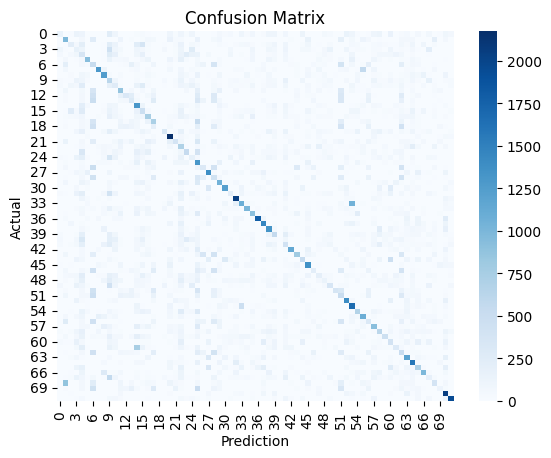

In [19]:
accuracy = np.sum(y_pred_argmax == y_test_argmax) / len(y_pred_argmax)
print("Accuracy: " + str(accuracy))

c_matrix = confusion_matrix(y_test_argmax,y_pred_argmax)
ax = sns.heatmap(c_matrix, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

And now we need to save the model in our S3 bucket to make it available outside of this Notebook. So please open up the [2-save_model.ipynb](2-save_model.ipynb) :)